In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [2]:
def save_filtered_data(file_list, charge_range, output_dir):
    """
    Filters and saves segmented data from input files based on a charge range, creating a directory with the specified name.

    Args:
        file_list (list of str): A list containing file paths to process.
        charge_range (tuple of int): A tuple containing two integers that define the lower and upper bounds of the charge range.
        output_dir (str): The name of the directory where the filtered data will be saved. This directory is created if it doesn't exist.

    Returns:
        None

    The function reads data from the provided files, segments it into chunks of 32, filters these segments based on the 
    provided charge range, and saves the filtered segments into CSV files in the specified output directory. 
    Each filtered file retains the original file name without the ".dat" extension within the output directory.
    """
    os.makedirs(output_dir, exist_ok=True)

    for file in file_list:
        file_name = os.path.basename(file).replace(".dat", "")
        filtered_data = []

        # Read data and segment
        data = np.loadtxt(file, np.int32, usecols=0)
        num_segments = len(data) // 32
        new_data = data[:num_segments * 32].reshape(-1, 32)

        # Filter the data
        for subsegment in new_data:
            if charge_range[0] < np.sum(subsegment) < charge_range[1]:
                filtered_data.append(subsegment)

        # Save the filtered data with the same original file name without ".dat"
        if filtered_data:
            output_file = os.path.join(output_dir, file_name + ".csv")
            np.savetxt(output_file, np.array(filtered_data), delimiter=',', fmt='%d')

    print(f"Saved in {output_dir}")

#### Use `download_files.py` (`README.md`)

In [3]:
file_list_AmBe_desnuda = sorted(glob.glob('AmBe/AmBe_salt/*AmBe_desnuda*'))
file_list_AmBe_plomo = sorted(glob.glob('AmBe/AmBe_salt/*AmBe_plomo*'))
file_list_AmBe_cdparafb = sorted(glob.glob('AmBe/AmBe_salt/*AmBe_cdparafb*'))
file_list_fondo = sorted(glob.glob('AmBe/AmBe_salt/*fondo*'))

#### AmBe (neutrons + gamma)

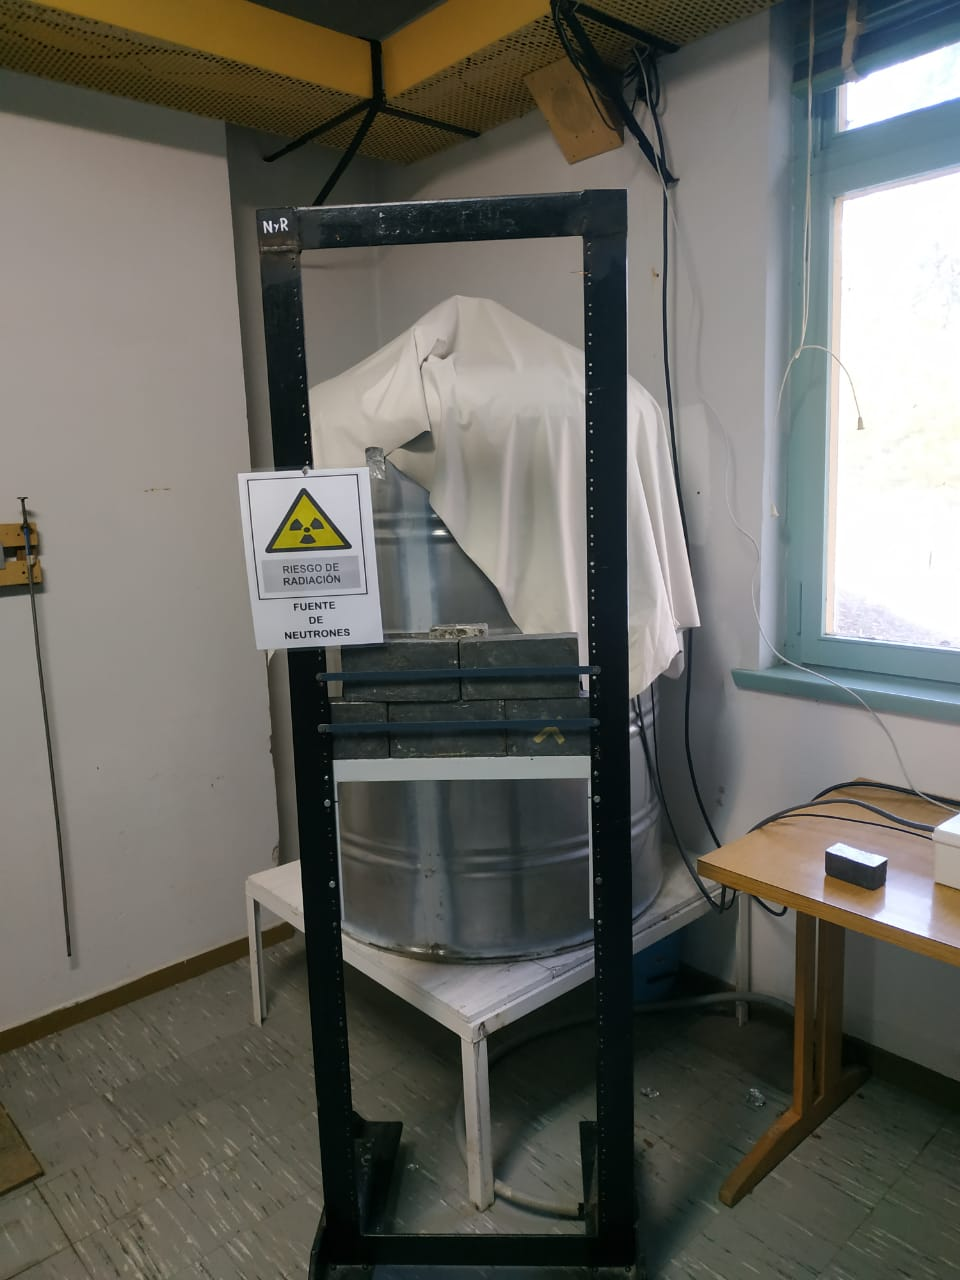

In [4]:
from IPython.display import Image

image_path = 'imgs/desnuda.jpg'

display(Image(filename=image_path, width=300, height=300))

In [5]:
# Charge thresholds for the AmBe source
charge_thresholds = (4000, 15000) 

In [6]:
save_filtered_data(file_list_AmBe_desnuda, charge_thresholds, "filtered_AmBe_salt/")

Saved in filtered_AmBe_salt/


#### Lead (neutrons)

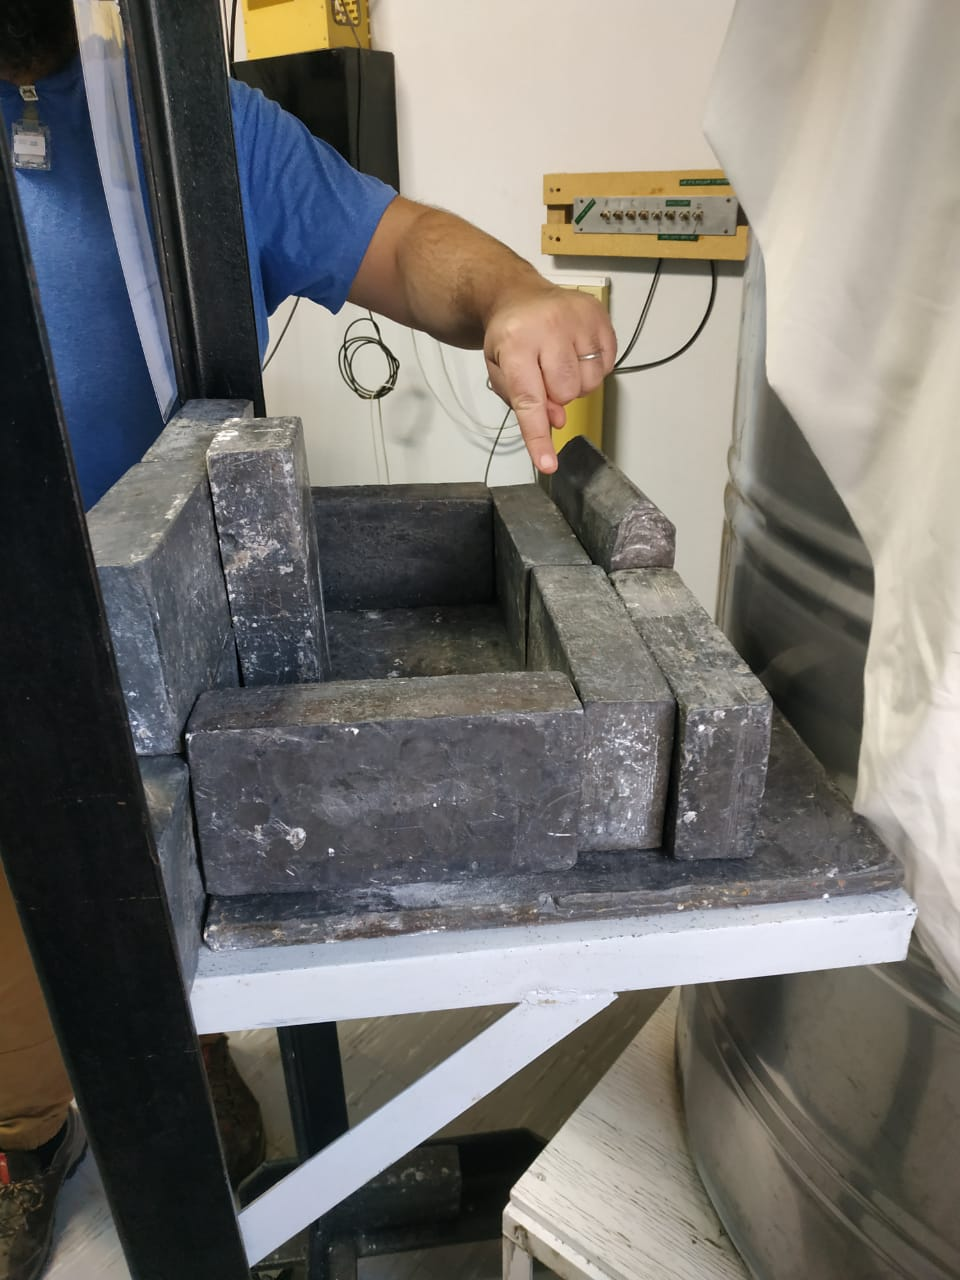

In [7]:
image_path = 'imgs/plomo.jpg'

display(Image(filename=image_path, width=300, height=300))

In [8]:
save_filtered_data(file_list_AmBe_plomo, charge_thresholds, "filtered_AmBe_salt/") 

Saved in filtered_AmBe_salt/


#### Borated Paraffin + Cd

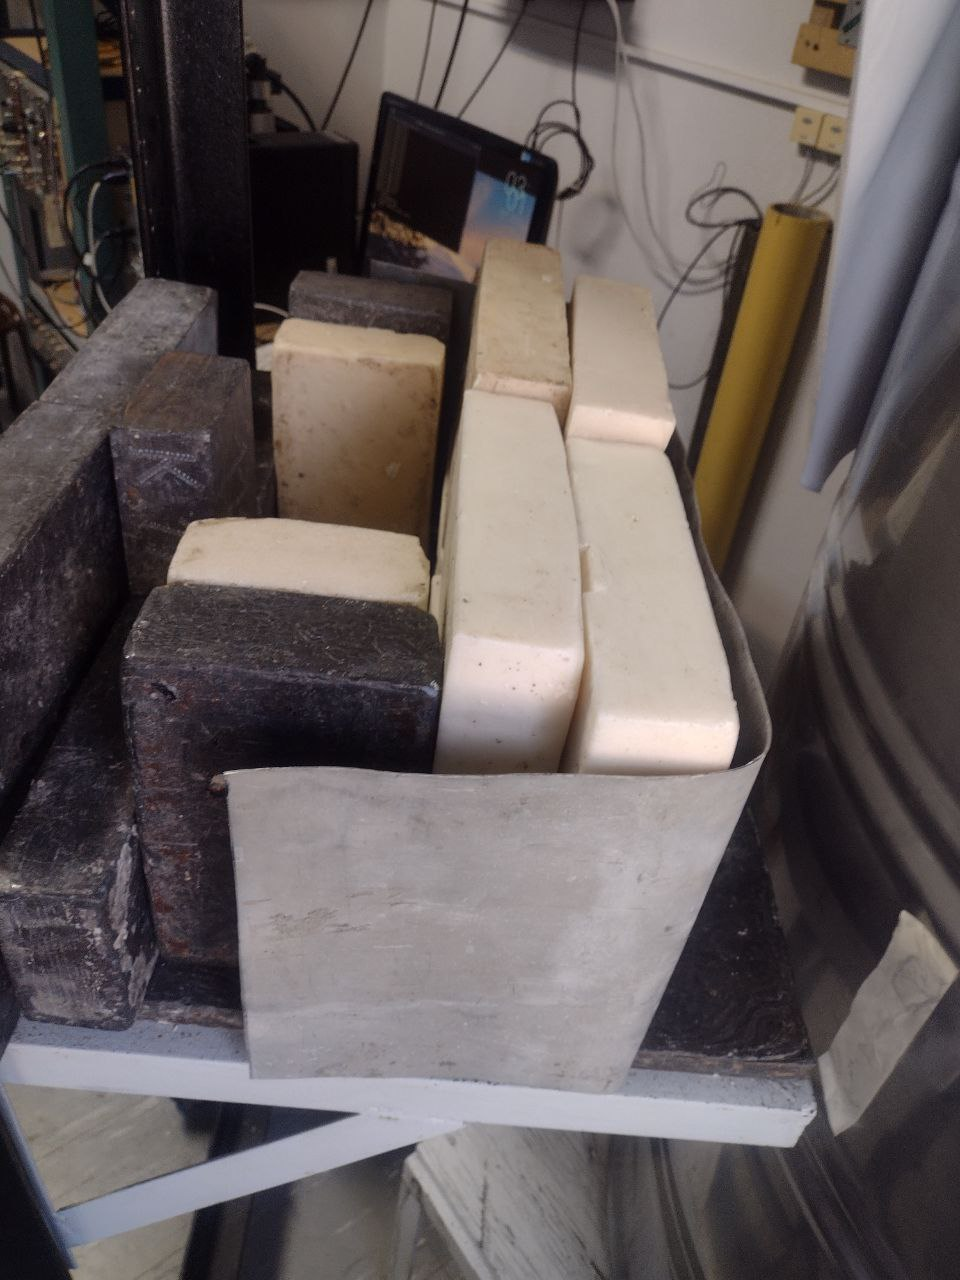

In [9]:
image_path = 'imgs/cdpb.jpg'

display(Image(filename=image_path, width=300, height=300))

In [10]:
save_filtered_data(file_list_AmBe_cdparafb, charge_thresholds, "filtered_AmBe_salt/") 

Saved in filtered_AmBe_salt/


In [11]:
save_filtered_data(file_list_fondo, charge_thresholds, "filtered_AmBe_salt/") 

Saved in filtered_AmBe_salt/


#### Charge espectrum

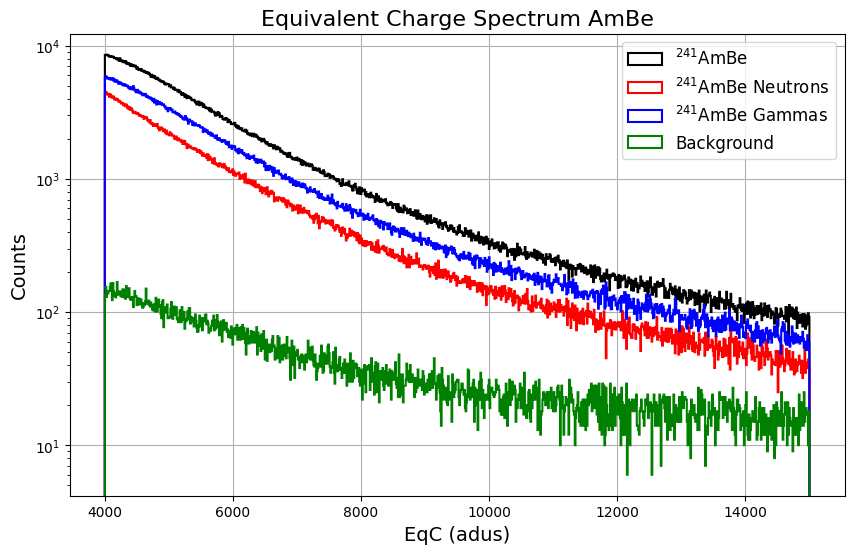

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import glob

# Function to load data from files and calculate the charge
def load_and_calculate_charge_from_directory(directory):
    """
    Loads data files from a specified directory, calculates the charge for each file, 
    and returns an array of all charges.
    Args:
        directory (str): The path to the directory containing the data files.
    Returns:
        np.ndarray: An array containing the calculated charges from all files.
    Notes:
        - The function assumes that the data files are in CSV format with integer values.
        - The charge is calculated as the sum of pulses (rows) in each file.
        - The function flattens the charges from all files into a single array.
    """
    files = sorted(glob.glob(f"{directory}"))
    all_charges = []
    
    for file in files:
        data = np.loadtxt(file, delimiter=',', dtype=np.int32)
        charges = np.sum(data, axis=1)  # Calculate the charge as the sum of pulses
        all_charges.extend(charges)  # Flatten and add to the list
        
    return np.array(all_charges)

# Load charges from different configurations
source_charges = load_and_calculate_charge_from_directory("filtered_AmBe_salt/AmBe_desnuda.csv")
source_charges_lead = load_and_calculate_charge_from_directory("filtered_AmBe_salt/AmBe_plomo.csv")
source_charges_cdparafb = load_and_calculate_charge_from_directory("filtered_AmBe_salt/AmBe_cdparafb.csv")
background_charges = load_and_calculate_charge_from_directory("filtered_AmBe_salt/fondo.csv")

# Create the plot
plt.figure(figsize=(10, 6))

plt.hist(source_charges, bins=1000, histtype='step', linewidth=1.5, label=r'$^{241}$AmBe', color='black')
plt.hist(source_charges_lead, bins=1000, histtype='step', linewidth=1.5, label=r'$^{241}$AmBe Neutrons', color='red')
plt.hist(source_charges_cdparafb, bins=1000, histtype='step', linewidth=1.5, label=r'$^{241}$AmBe Gammas', color='blue')
plt.hist(background_charges, bins=1000, histtype='step', linewidth=1.5, label='Background', color='green')

# plt.title('Equivalent Charge Spectrum AmBe', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)  
plt.xlabel('EqC (adus)', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.grid()
plt.legend(fontsize=12)
plt.yscale('log')

plt.savefig('results_pure/charge_pure.png', dpi=300, bbox_inches='tight')

plt.show()

#### Mean Pulses

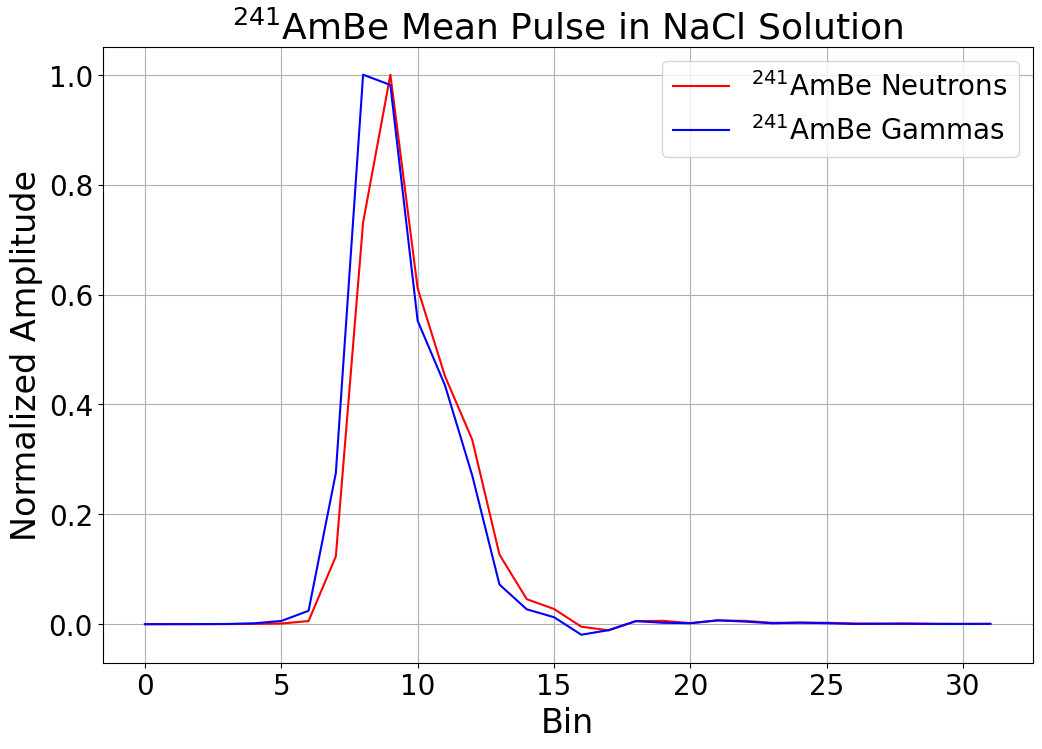

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def load_and_calculate_average_pulse_from_file(file_path, type):
    """
    Loads pulse data from a CSV file, calculates the overall average pulse,
    and returns the average pulse.

    Args:
        file_path (str): Path to the CSV file containing the pulse data.
        type (str): Type of pulse (e.g., "neutrones" or "gammas").

    Returns:
        np.ndarray: The average pulse calculated from the file.
    """
    data = np.loadtxt(file_path, delimiter=',', dtype=np.int32)
    average_pulse = np.mean(data, axis=0)  # Calculate the average pulse
    return average_pulse

def reshape_pulses(pulses):
    if pulses.ndim == 1:  # If the array is 1D, convert it to 2D
        pulses = pulses.reshape(1, -1)
    return pulses / np.max(np.abs(pulses), axis=1, keepdims=True)

# Load and process data
average_pulses_plomo = load_and_calculate_average_pulse_from_file('filtered_AmBe_salt/AmBe_plomo.csv', 'neutrones')
average_pulses_cdparafinab = load_and_calculate_average_pulse_from_file('filtered_AmBe_salt/AmBe_cdparafb.csv', 'gammas')

reshaped_average_pulses_plomo = reshape_pulses(np.array(average_pulses_plomo))
reshaped_average_pulses_cdparafinab = reshape_pulses(np.array(average_pulses_cdparafinab))

# Create the plot
plt.figure(figsize=(12, 8))

x_values = np.arange(len(reshaped_average_pulses_plomo[0]))

plt.plot(x_values, np.mean(reshaped_average_pulses_plomo, axis=0), label=r'$^{241}$AmBe Neutrons', color='red', linestyle='-')
plt.plot(x_values, np.mean(reshaped_average_pulses_cdparafinab, axis=0), label=r'$^{241}$AmBe Gammas', color='blue', linestyle='-')

plt.tick_params(axis='both', labelsize=20)
# plt.title(r'$^{241}$AmBe Mean Pulse in NaCl Solution', fontsize=26) 
plt.xlabel('Bin', fontsize=24)
plt.ylabel('Normalized Amplitude', fontsize=24) 
plt.grid()
plt.legend(fontsize=20)

# Save the image in high resolution
plt.savefig('results_salt/pulse_salt.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [14]:
print(reshaped_average_pulses_plomo)
print(reshaped_average_pulses_cdparafinab)

[[ 2.41401787e-04  3.34194929e-04  3.94429740e-04  4.82884304e-04
   7.57954710e-04  1.46742714e-03  5.95362129e-03  1.23648347e-01
   7.31353038e-01  1.00000000e+00  6.11210577e-01  4.51858857e-01
   3.36121477e-01  1.26843487e-01  4.57763396e-02  2.79471232e-02
  -4.26471202e-03 -1.09205105e-02  5.71056879e-03  6.39347123e-03
   2.12727946e-03  7.04020999e-03  6.29338856e-03  2.78117478e-03
   3.06013072e-03  2.85237476e-03  1.50677447e-03  1.29411481e-03
   1.52238499e-03  1.07756772e-03  9.18896199e-04  9.81271806e-04]]
[[ 2.86061462e-04  3.69296481e-04  4.49525059e-04  6.67050251e-04
   1.92837298e-03  6.09407776e-03  2.46577352e-02  2.75239107e-01
   1.00000000e+00  9.81422438e-01  5.52298271e-01  4.35128296e-01
   2.71090243e-01  7.23769686e-02  2.73398162e-02  1.29746812e-02
  -1.89037341e-02 -1.06319210e-02  5.93195198e-03  2.80575815e-03
   2.11069529e-03  7.32720424e-03  5.00650749e-03  1.92309530e-03
   3.03839644e-03  2.09882796e-03  7.87542611e-04  9.90478439e-04
   1.041

#### Preprocessing

In [15]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def load_data(neutron_file, gamma_file):
    """
    Load neutron and gamma data from CSV files, validate dimensions, and create labels.
    Parameters:
    neutron_file (str): Path to the CSV file containing neutron data.
    gamma_file (str): Path to the CSV file containing gamma data.
    Returns:
    tuple: A tuple containing:
        - data (numpy.ndarray): Combined data from both neutron and gamma files.
        - labels (numpy.ndarray): Array of labels where 1 represents neutron data and 0 represents gamma data.
    Raises:
    ValueError: If the neutron and gamma data have a different number of features (columns).
    """
    # Load data from files
    neutron_pulses = pd.read_csv(neutron_file, header=None).values
    gamma_pulses = pd.read_csv(gamma_file, header=None).values

    # Validate dimensions
    if neutron_pulses.shape[1] != gamma_pulses.shape[1]:
        raise ValueError("Neutron and gamma data have a different number of features.")

    # Create labels and concatenate data
    labels = np.array([1] * neutron_pulses.shape[0] + [0] * gamma_pulses.shape[0])
    data = np.vstack((neutron_pulses, gamma_pulses))

    return data, labels

def balance_data(X_train, y_train):
    """
    Balances the dataset by first oversampling the minority class using SMOTE and then undersampling using TomekLinks.
    Parameters:
    X_train (array-like or DataFrame): The input features for training.
    y_train (array-like or Series): The target labels for training.
    Returns:
    tuple: A tuple containing the resampled input features and target labels.
    """
   
    print(f'Before balancing: {X_train[y_train == 1].shape[0]} neutrons, {X_train[y_train == 0].shape[0]} gammas')

    # Oversampling with SMOTE
    oversample = SMOTE(random_state=42)
    X_resampled, y_resampled = oversample.fit_resample(X_train, y_train)
    
    # Undersampling with TomekLinks
    X_resampled, y_resampled = TomekLinks().fit_resample(X_resampled, y_resampled)

    print(f'After balancing: {X_resampled[y_resampled == 1].shape[0]} neutrons, {X_resampled[y_resampled == 0].shape[0]} gammas')

    return X_resampled, y_resampled

def preprocess_data(neutron_file, gamma_file):
    """
    Preprocess the neutron and gamma data by loading, splitting, and balancing.
    Parameters:
    neutron_file (str): Path to the file containing neutron data.
    gamma_file (str): Path to the file containing gamma data.
    Returns:
    tuple: A tuple containing the following elements:
        - X_train (array-like): Training data features.
        - X_test (array-like): Testing data features.
        - y_train (array-like): Training data labels.
        - y_test (array-like): Testing data labels.
    """

    data, labels = load_data(neutron_file, gamma_file)
    
    # Split into training and testing sets (80/20 stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=0.2, random_state=42, stratify=labels
    )

    # Balance classes only in the training set
    X_train, y_train = balance_data(X_train, y_train)

    return X_train, X_test, y_train, y_test

# Input files
neutron_file = 'filtered_AmBe_salt/AmBe_plomo.csv'
gamma_file = 'filtered_AmBe_salt/AmBe_cdparafb.csv'

# Load data, preprocess, split into training and testing sets
X_train, X_test, y_train, y_test = preprocess_data(neutron_file, gamma_file)

Before balancing: 504654 neutrons, 753422 gammas


In [4]:
# Basic Statistical Analysis
print(pd.DataFrame(X_train).describe())

Análisis estadístico de las características:
                 0             1             2             3             4   \
count  1.469230e+06  1.469230e+06  1.469230e+06  1.469230e+06  1.469230e+06   
mean   4.415776e-01  5.931202e-01  6.995583e-01  9.530332e-01  2.237620e+00   
std    1.816342e+01  1.978579e+01  2.053721e+01  2.199093e+01  3.180849e+01   
min   -7.800000e+01 -1.080000e+02 -1.160000e+02 -8.500000e+01 -7.500000e+01   
25%   -5.000000e+00 -5.000000e+00 -5.000000e+00 -5.000000e+00 -5.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    4.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00   
max    9.980000e+02  9.880000e+02  9.970000e+02  9.990000e+02  9.990000e+02   

                 5             6             7             8             9   \
count  1.469230e+06  1.469230e+06  1.469230e+06  1.469230e+06  1.469230e+06   
mean   6.243839e+00  2.509175e+01  3.247648e+02  1.407829e+03  1.616462e+03   
std   

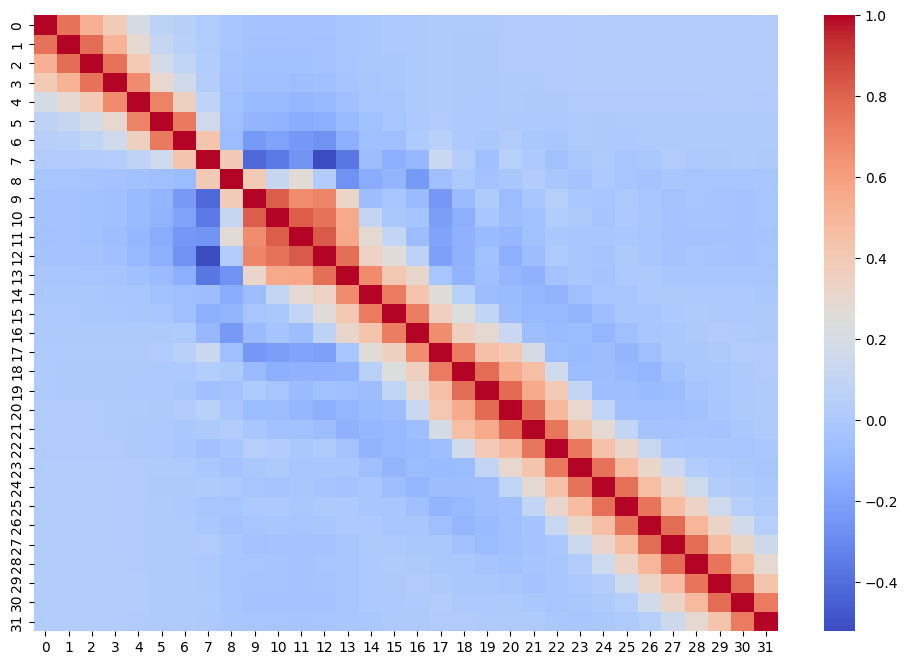

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you already have X_train and the libraries imported
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(X_train).corr(), cmap='coolwarm', annot=False)

# Save the image in high resolution
plt.savefig('results_salt/corr_salt.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [7]:
# Scale balanced data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Scale the test set using the same scaler
X_test = scaler.transform(X_test)

os.makedirs("results_salt/models", exist_ok=True)

# Save the scaler
joblib.dump(scaler, "results_salt/models/scaler_salt.pkl")

['models/scaler_salt.pkl']

In [8]:
# Create directory to save data
output_dir = "preprocessed_data_salt"
os.makedirs(output_dir, exist_ok=True)

# Save the balanced data
pd.DataFrame(X_train).to_csv(os.path.join(output_dir, "X_train.csv"), index=False, header=False)
pd.DataFrame(y_train).to_csv(os.path.join(output_dir, "y_train.csv"), index=False, header=False)
pd.DataFrame(X_test).to_csv(os.path.join(output_dir, "X_test.csv"), index=False, header=False)
pd.DataFrame(y_test).to_csv(os.path.join(output_dir, "y_test.csv"), index=False, header=False)

print(f"Preprocessed files saved in: {output_dir}")

Archivos preprocesados guardados en: preprocessed_data_salt


## Train and evaluate base classifiers

In [9]:
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, log_loss
)
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import logging
import warnings
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import gc

# Clasificadores
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, NearestCentroid
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [10]:
# Configuración de logging y warnings
logging.getLogger('lightgbm').setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

#### Clasificadores base a comparar

In [11]:
classifiers = {
    "LinearSVC": LinearSVC(max_iter=1000, dual=False),
    "LGBMClassifier": LGBMClassifier(force_col_wise=True, verbose=-1),
    "RandomForestClassifier": RandomForestClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "HistGradientBoostingClassifier": HistGradientBoostingClassifier(max_iter=100),
    "XGBClassifier": XGBClassifier(),
    "CatBoostClassifier": CatBoostClassifier(silent=True),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=3, metric="euclidean"),
    "GaussianNB": GaussianNB(),
    "PassiveAggressiveClassifier": PassiveAggressiveClassifier(max_iter=1000),
    "NearestCentroidClassifier": NearestCentroid(),
    "QuadraticDiscriminantAnalysis": QuadraticDiscriminantAnalysis()
}


In [ ]:
# Evaluation of classifiers with cross-validation
results = []

for clf_name, clf in classifiers.items():
    print(f"Evaluating: {clf_name}...")
    
    # Fit the classifier for evaluation on the test set
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Calculate log-loss if the classifier supports it
    if hasattr(clf, "predict_proba"):
        y_pred_proba = clf.predict_proba(X_test)
        log_loss_value = log_loss(y_test, y_pred_proba)
    else:
        log_loss_value = None

    metrics = {
        "Classifier": clf_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted"),
        "Recall": recall_score(y_test, y_pred, average="weighted"),
        "F1-Score": f1_score(y_test, y_pred, average="weighted"),
        "Log Loss": log_loss_value
    }

    results.append(metrics)
    del clf
    gc.collect()

Evaluando: LinearSVC...
Evaluando: LGBMClassifier...
Evaluando: RandomForestClassifier...
Evaluando: GradientBoostingClassifier...
Evaluando: HistGradientBoostingClassifier...
Evaluando: XGBClassifier...
Evaluando: CatBoostClassifier...
Evaluando: LogisticRegression...
Evaluando: AdaBoostClassifier...
Evaluando: KNeighborsClassifier...
Evaluando: GaussianNB...
Evaluando: PassiveAggressiveClassifier...
Evaluando: NearestCentroidClassifier...
Evaluando: QuadraticDiscriminantAnalysis...


In [ ]:
results_df = pd.DataFrame(results)
print(results_df)

# Save results to a CSV file
results_df.to_csv("results_salt/classification_results_salt.csv", index=False)

                        Classifier  Accuracy  Precision    Recall  F1-Score  \
0                        LinearSVC  0.674147   0.692518  0.674147  0.677360   
1                   LGBMClassifier  0.738973   0.740373  0.738973  0.728162   
2           RandomForestClassifier  0.745294   0.752312  0.745294  0.731473   
3       GradientBoostingClassifier  0.745634   0.753984  0.745634  0.731089   
4   HistGradientBoostingClassifier  0.739030   0.740403  0.739030  0.728251   
5                    XGBClassifier  0.731972   0.729362  0.731972  0.724857   
6               CatBoostClassifier  0.732770   0.730180  0.732770  0.725752   
7               LogisticRegression  0.675215   0.690943  0.675215  0.678358   
8               AdaBoostClassifier  0.733367   0.730817  0.733367  0.726373   
9             KNeighborsClassifier  0.661884   0.685448  0.661884  0.665139   
10                      GaussianNB  0.637262   0.693193  0.637262  0.636549   
11     PassiveAggressiveClassifier  0.630121   0.625